<div style="display: block; height: 500px; overflow:hidden;position: relative">
     <img src="https://imgur.com/6I1AHP5.jpg" style="position: absolute;top: 0px;">
</div>

# 1.  Imports

In [48]:
# generics
import pandas as pd
import numpy as np

# visu
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# texts
import re
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2.  Loading data

In [53]:
df_train = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv", encoding="latin_1")
df_test = pd.read_csv("/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv", encoding="latin_1")

# 3.  Data overview

In [54]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
33017,36816,81768,"Fort Atkinson, WI",07-04-2020,Adobe has found that due to the #Coronavirus (...,Positive
33144,36943,81895,"Coimbatore, India",07-04-2020,Coimbatore North Round Table 20 handed over 20...,Extremely Positive
14746,18545,63497,Los Angeles County,22-03-2020,We re here to help you during this difficult t...,Neutral
16363,20162,65114,"Official page, Purdue EVPRP",22-03-2020,Purdue virologist Richard Kuhn joined and cons...,Positive
26830,30629,75581,"Lyon, France",02-04-2020,"Sit tight, people. This Wuhan Virus will wipe ...",Extremely Positive


In [55]:
print("train set shape: " + str(df_train_clean.shape))
print("test set shape: " + str(df_test_clean.shape))

train set shape: (41100, 7)
test set shape: (3795, 7)


In [56]:
max_tweet_length = 0
tweet_length = []
#
for tweet in df_train["OriginalTweet"]:
    tweet_length.append(len(tweet))
    if len(tweet) > max_tweet_length:
        max_tweet_length = len(tweet)
print("Longest tweet: " + str(max_tweet_length) + " characters")

Longest tweet: 355 characters


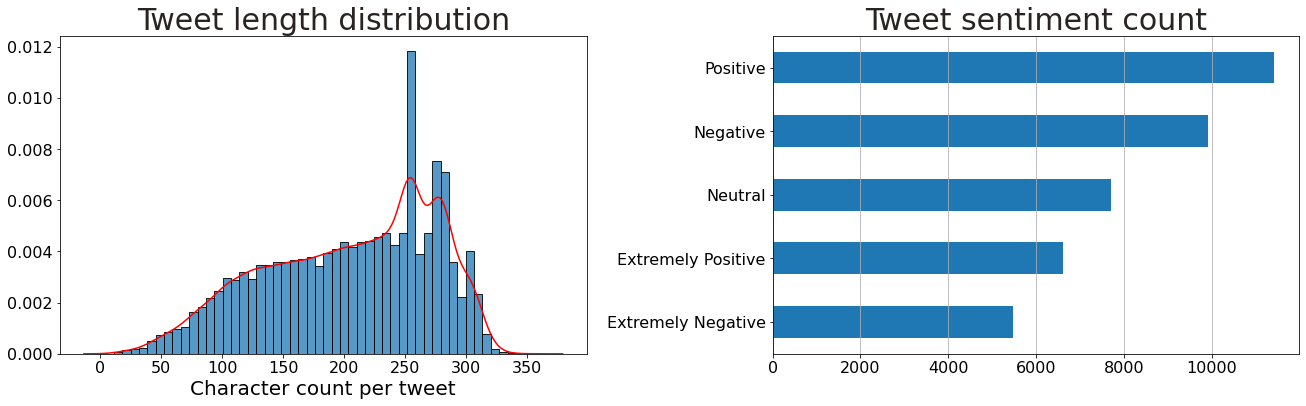

In [57]:
parameters = {'axes.labelsize': 20,
              'axes.titlesize': 30}
#
plt.rcParams.update(parameters)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6)
sns.histplot(tweet_length, palette='Blues', stat='density', bins=50, ax=ax1);
sns.kdeplot(tweet_length, color='red', ax=ax1)
ax1.set_xlabel('Character count per tweet');
df_train["Sentiment"].reset_index().groupby("Sentiment").count().rename(columns={"index": "Count"}).sort_values(by= 
       "Count").plot(kind="barh", legend=False, 
        ax=ax2).grid(axis='x')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylabel("")
ax1.set_title("Tweet length distribution", color ="#292421")
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylabel("")
ax2.set_title("Tweet sentiment count", color ="#292421")
fig.tight_layout(pad=2.0)
plt.rcParams.update(parameters)

# 4.  Turning 5 categories into 3 categories
Here we convert <b>extremely positive</b> tweets into <b style="color: green">positive</b> and <b>extremely negative</b> tweets into <b style="color: red">negative</b>.

In [58]:
def set_3_classes(x):
  if x=="Extremely Negative":
    return "Negative"
  elif x=="Extremely Positive":
    return "Positive"
  else:
    return x

In [59]:
df_train["Sentiment"] = df_train["Sentiment"].apply(set_3_classes)
df_test["Sentiment"] = df_test["Sentiment"].apply(set_3_classes)

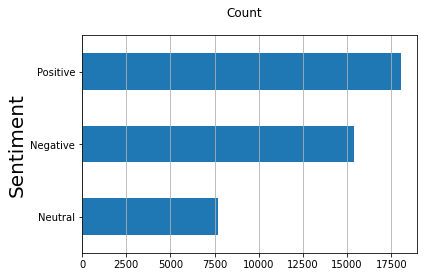

In [60]:
fig, ax = plt.subplots()
fig.suptitle("Count", fontsize=12)
df_train["Sentiment"].reset_index().groupby("Sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# 5. Cleaning tweets

In [62]:
df_train["CleanTweet"] = df_train["OriginalTweet"]
df_train.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
26528,30327,75279,New York and California,02-04-2020,Heiliger Strohsack! GermanyÂs Biggest Departm...,Negative,Heiliger Strohsack! GermanyÂs Biggest Departm...
31761,35560,80512,"Washington, DC",07-04-2020,Tsutomu Watanabe News en compares the response...,Negative,Tsutomu Watanabe News en compares the response...
34459,38258,83210,"Colorado, USA",08-04-2020,@AOC Any American who thinks we should deport ...,Positive,@AOC Any American who thinks we should deport ...


<b>Removing end-of-line, tabulation and carriage return. Turning into lower case:</b>

In [63]:
def lowerize(df, label):
    """ text lowercase
        removes \n
        removes \t
        removes \r """
    df[label] = df[label].str.lower()
    df[label] = df[label].apply(lambda x: x.replace("\n", " "))
    df[label] = df[label].apply(lambda x: x.replace("\r", " "))
    df[label] = df[label].apply(lambda x: x.replace("\t", " "))
    return df
#
df_train = lowerize(df_train, "CleanTweet")

<b>Removing e-mails:</b>

In [64]:
def remove_emails(df, label):
    """ This function removes email adresses
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])""", " ", x))
    return df
#
df_train = remove_emails(df_train, "CleanTweet")

<b>Removing mentions:</b>

In [65]:
def remove_mentions(df, label):
    """ This function removes mentions (Twitter - starting with @) from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"@([a-zA-Z0-9_.-]{1,100})", " ", x))
    return df
#
df_train = remove_mentions(df_train, "CleanTweet")

<b>Removing hyperlinks:</b>

In [66]:
def remove_hyperlinks(df, label):
    """ This function removes hyperlinks from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"http\S+", " ", x))
    return df
#
df_train = remove_hyperlinks(df_train, "CleanTweet")

<b>Removing hashtags:</b>

In [67]:
def remove_hashtags(df, label):
    """ This function removes hashtags
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"#\w+", " ", x))
    return df
#
df_train = remove_hashtags(df_train, "CleanTweet")

<b>Removing html tags:</b>

In [68]:
def remove_html_tags(df, label):
    """ This function removes html tags from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"<.*?>", " ", x))
    return df
#
df_train = remove_html_tags(df_train, "CleanTweet")

<b>Removing numbers:</b>

In [69]:
def remove_numbers(df, label):
    """ This function removes numbers from a text
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"\d+", " ", x))
    return df
#
df_train = remove_numbers(df_train, "CleanTweet")

<b>Encode unknown characters:</b>

In [70]:
def encode_unknown(df, label):
    """ This function encodes special caracters """
    df[label] = df[label].apply(lambda x: unicodedata.normalize("NFD", x).encode('ascii', 'ignore').decode("utf-8"))
    return df
#
df_train = encode_unknown(df_train, "CleanTweet")

<b>Removing punctuations and special characters:</b><br>
*Note this function will remove punctuation AND accented characters. Thus it is not necessary usable on languages that have accented characters. But for english it is ok.*

In [71]:
def clean_punctuation_no_accent(df, label):
    """ This function removes punctuation and accented characters from texts in a dataframe 
        To be appplied to languages that have no accents, ex: english 
    """
    df[label] = df[label].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    return df
#
df_train = clean_punctuation_no_accent(df_train, "CleanTweet")

<b>Removing stop words. Here, the list is from nltk stopwords library:</b>

In [72]:
def remove_stop_words(text, stopwords=set(stopwords.words('english'))):
    """ This function removes stop words from a text
        inputs:
         - stopword list
         - text """

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()
    
    # stop words updated
    #stopwords = stopwords.union({"grocery store", "covid", "supermarket", "people", "grocery", "store", "price", "time"})
    
    # loop
    for word in text_splitted:
        if word not in stopwords:
            text_new.append(word)
    return " ".join(text_new)

def clean_stopwords(df, label):
    """ This function removes stopwords """
    df[label] = df[label].apply(lambda x: remove_stop_words(x))
    return df
#
df_train = clean_stopwords(df_train, "CleanTweet")

<b>Removing one and two letters words, removing unnecessary spaces, droping empty lines:</b>

In [73]:
def more_cleaning(df, label):
    """ This function
     1) removes remaining one-letter words and two letters words
     2) replaces multiple spaces by one single space
     3) drop empty lines """
    df[label] = df[label].apply(lambda x: re.sub(r'\b\w{1,2}\b', " ", x))
    df[label] = df[label].apply(lambda x: re.sub(r"[ \t]{2,}", " ", x))
    df[label] = df[label].apply(lambda x: x if len(x) != 1 else '')
    df[label] = df[label].apply(lambda x: np.nan if x == '' else x)
    df = df.dropna(subset=[label], axis=0).reset_index(drop=True).copy()
    return df
#
df_train = more_cleaning(df_train, "CleanTweet")

<b>Lemmatizing words:</b>

In [74]:
def lemmatize_one_text(text):
    """ This function lemmatizes words in text (it changes word to most close root word)
        inputs:
         - lemmatizer
         - text """

    # initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()

    # loop
    for word in text_splitted:
        text_new.append(lemmatizer.lemmatize(word))

    return " ".join(text_new)

def lemmatize(df, label):
    """ This function lemmatizes texts """
    df[label] = df[label].apply(lambda x: lemmatize_one_text(x))
    return df
#
df_train = lemmatize(df_train, "CleanTweet")

In [75]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
28951,32784,77736,"Sacramento, CA",05-04-2020,"Reminder: price gouging is ILLEGAL, and Califo...",Negative,reminder price gouging illegal californian pro...
15438,19261,64213,"Houston, TX",22-03-2020,"Come poop with us, Danny. But be warned. There...",Negative,come poop danny warned toilet paper forevah ev...
24443,28274,73226,"Sacramento, CA",26-03-2020,How is #Coronavirus changing the work of State...,Neutral,changing work state ag law published oped tho...
3718,7524,52476,NaN,18-03-2020,Panic-buying in response to #Covid19 could hav...,Negative,panic buying response could damaging effect ag...
34568,38413,83365,"North Springfield, VA ????",08-04-2020,Someone at my daughters job grocery store test...,Positive,someone daughter job grocery store tested posi...


### Let's apply all of these cleaning on test data set as well:

In [76]:
df_test["CleanTweet"] = df_test["OriginalTweet"]
df_test = lowerize(df_test, "CleanTweet")
df_test = remove_emails(df_test, "CleanTweet")
df_test = remove_mentions(df_test, "CleanTweet")
df_test = remove_hyperlinks(df_test, "CleanTweet")
df_test = remove_hashtags(df_test, "CleanTweet")
df_test = remove_html_tags(df_test, "CleanTweet")
df_test = remove_numbers(df_test, "CleanTweet")
df_test = encode_unknown(df_test, "CleanTweet")
df_test = clean_punctuation_no_accent(df_test, "CleanTweet")
df_test = clean_stopwords(df_test, "CleanTweet")
df_test = more_cleaning(df_test, "CleanTweet")
df_test = lemmatize(df_test, "CleanTweet")

In [77]:
df_test.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
2163,2164,47116,"Sepang, Selangor",13-03-2020,Covid-19 force us to use online video conferen...,Neutral,covid force use online video conference call c...
1492,1493,46445,Texas,13-03-2020,"Yesterday in my small town: ""They cancelled th...",Negative,yesterday small town cancelled rodeo liberal b...
1845,1846,46798,philippines,13-03-2020,Arrived in Ayala earlier today where people we...,Neutral,arrived ayala earlier today people already bul...


### Let's have a look on before/after cleaning on several tweets:

In [78]:
tweet_num = 3456
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################
This supermarket in Australia opened its doors an hour earlier than usual, so that elderly and disabled customers can shop comfortably without the #coronavirus panic-buying frenzies ???? https://t.co/lDAU8CdWEa


############################# Clean Tweet ################################
supermarket australia opened door hour earlier usual elderly disabled customer shop comfortably without panic buying frenzy 


In [79]:
tweet_num = 34050
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################
Watching @DeborahNorville &amp; @AnnMercogliano  on @InsideEdition talking about grocery store workers. May we all take a moment to pray for them &amp; their families. They are part of the front-line. We owe all of you a debt of gratitude. ?? 
#coronavirus


############################# Clean Tweet ################################
watching amp talking grocery store worker may take moment pray amp family part front line owe debt gratitude 


It looks good

# 6.  Looking at data

<b>Sentiment repartition:</b>

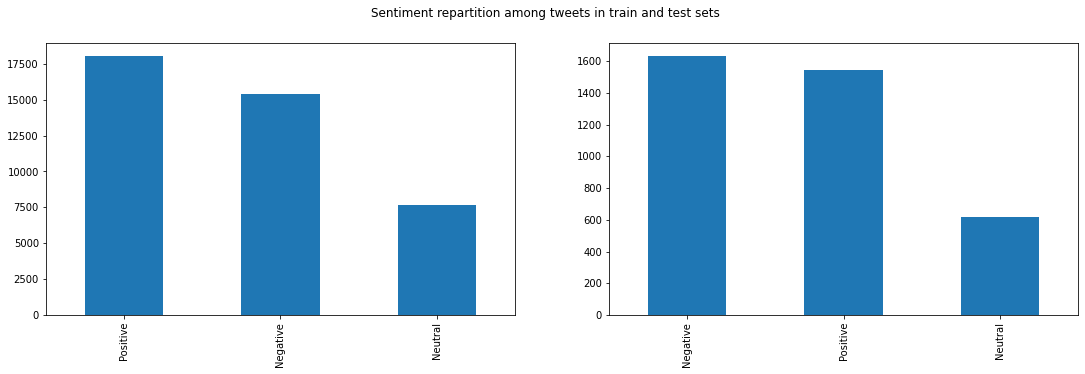

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
fig.suptitle('Sentiment repartition among tweets in train and test sets')
df_train["Sentiment"].value_counts().plot(kind="bar", ax=ax1);
df_test["Sentiment"].value_counts().plot(kind="bar", ax=ax2);

<b>Word cloud in each sentiment categories:</b>

In [81]:
all_words_positive = " ".join([text for text in df_train[df_train["Sentiment"]=="Positive"]["CleanTweet"]])
all_words_neutral = " ".join([text for text in df_train[df_train["Sentiment"]=="Neutral"]["CleanTweet"]])
all_words_negative = " ".join([text for text in df_train[df_train["Sentiment"]=="Negative"]["CleanTweet"]])

In [82]:
wordcloud_positive = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Greens").generate(all_words_positive)
wordcloud_neutral = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="YlOrBr").generate(all_words_neutral)
wordcloud_negative = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Reds").generate(all_words_negative)

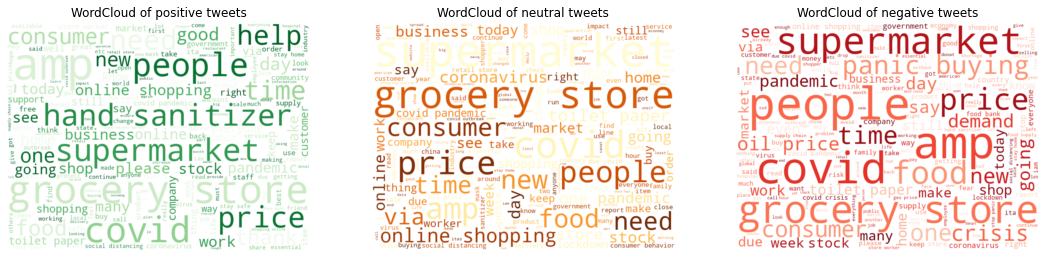

In [83]:
parameters = {'axes.labelsize': 12,
              'axes.titlesize': 10}
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 7)
ax1.imshow(wordcloud_positive, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("WordCloud of positive tweets", fontsize=12)
ax2.imshow(wordcloud_neutral, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("WordCloud of neutral tweets", fontsize=12)
ax3.imshow(wordcloud_negative, interpolation='bilinear')
ax3.axis("off")
ax3.set_title("WordCloud of negative tweets", fontsize=12)
plt.rcParams.update(parameters)
plt.show()

# 7. Sentiment encoding

In [86]:
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()
#
print("train set shape: " + str(df_train_encoded.shape))
print("test set shape: " + str(df_test_encoded.shape))

train set shape: (41100, 7)
test set shape: (3795, 7)


In [87]:
map_sentiment = {"Neutral":0, "Positive":1,"Negative":2}
df_train_encoded['Sentiment'] = df_train_encoded['Sentiment'].map(map_sentiment)
df_test_encoded['Sentiment']  = df_test_encoded['Sentiment'].map(map_sentiment)

# 8. Feature and target preparation

In [90]:
y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()
#
y_train_encoded = to_categorical(df_train_encoded['Sentiment'], 3)
y_test_encoded = to_categorical(df_test_encoded['Sentiment'], 3)
#
y_train_mapped = df_train_encoded['Sentiment'].copy()
y_test_mapped = df_test_encoded['Sentiment'].copy()
#
X_train = df_train_encoded[['CleanTweet']].copy()
X_test = df_test_encoded[['CleanTweet']].copy()

# 9. Tokenization, sequences, padding

<b>The result of tokenizer is a dictionnary with:</b><br>
* key = word<br>
* value = unique number

In [100]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["CleanTweet"])
vocab_length = len(tokenizer.word_index) + 1
vocab_length

30445

The <b>texts_to_sequences</b> function first transforms a text into list of words. Then, thanks to the dictionnary previously created by the tokenizer (see above), transforms list of list of words into list of list of numbers

In [101]:
X_train = tokenizer.texts_to_sequences(X_train["CleanTweet"])
X_test = tokenizer.texts_to_sequences(X_test["CleanTweet"])

Each tweets has differents length. Thus the result of the <b>texts_to_sequences</b> function will be a list of list of numbers of different length: 

In [102]:
print("First tweet encoded:")
print(X_train[0])
print("\nSecond tweet encoded:")
print(X_train[1])
print("\nThird tweet encoded:")
print(X_train[2])

First tweet encoded:
[387, 492, 1463, 96, 2123, 605, 260, 911, 303, 257, 605, 260, 1463, 352, 1620, 1892, 341, 11, 10, 781, 4020, 2618, 27, 854, 1977, 91]

Second tweet encoded:
[23, 769, 3734, 173, 220, 1235, 1526, 10, 105, 87, 1, 65]

Third tweet encoded:
[5, 25, 26, 133, 36, 18, 156, 5, 74, 59, 12, 45, 812, 45, 90]


To feed the deep learning model, we need all these lists to be the same length. Thus we need to apply padding. In other words, we are going to add several zeros (0) at the end of the shortest tweets so that at the end, all of our lists have the same length. <br><br>
First let's get the maximum number of words in one tweet:

In [103]:
max_word_count = 0
word_count = []
#
for encoded_tweet in X_train:
    word_count.append(len(encoded_tweet))
    if len(encoded_tweet) > max_word_count:
        max_word_count = len(encoded_tweet)
print("Maximum number of word in one tweet: " + str(max_word_count) + " words")

Maximum number of word in one tweet: 37 words


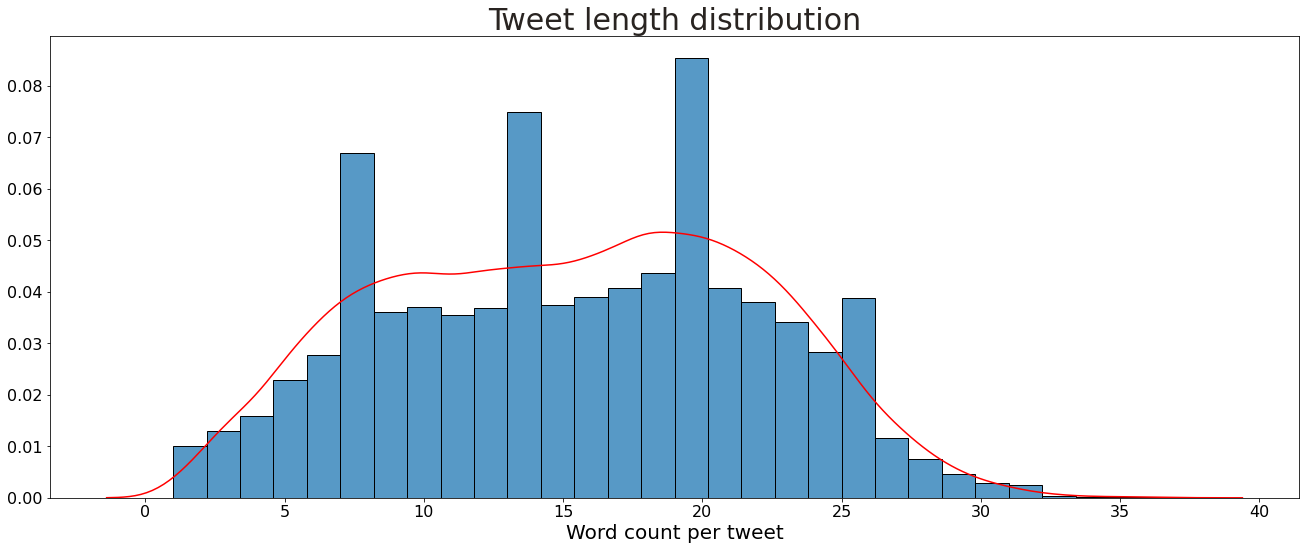

In [104]:
parameters = {'axes.labelsize': 20,
              'axes.titlesize': 30}
#
plt.rcParams.update(parameters)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18.5, 8)
sns.histplot(word_count, palette='Blues', stat='density', bins=30, ax=ax1);
sns.kdeplot(word_count, color='red', ax=ax1)
ax1.set_xlabel('Word count per tweet');
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylabel("")
ax1.set_title("Tweet length distribution", color ="#292421")
fig.tight_layout(pad=2.0)
plt.rcParams.update(parameters)

So the longest tweet we have is composed of 37 words. We are going to pad the sequences with a maximum length of 37.

In [105]:
X_train = pad_sequences(X_train, maxlen=max_word_count, padding='post')
X_test = pad_sequences(X_test, maxlen=max_word_count, padding='post')
X_train.shape

(41100, 37)

Let's have a look at the encoded 3 tweets after padding:

In [106]:
print("First tweet encoded:", "Size = ", len(X_train[0]))
print(X_train[0])
print("\nSecond tweet encoded:", "Size = ", len(X_train[1]))
print(X_train[1])
print("\nThird tweet encoded:", "Size = ", len(X_train[2]))
print(X_train[2])

First tweet encoded: Size =  37
[ 387  492 1463   96 2123  605  260  911  303  257  605  260 1463  352
 1620 1892  341   11   10  781 4020 2618   27  854 1977   91    0    0
    0    0    0    0    0    0    0    0    0]

Second tweet encoded: Size =  37
[  23  769 3734  173  220 1235 1526   10  105   87    1   65    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]

Third tweet encoded: Size =  37
[  5  25  26 133  36  18 156   5  74  59  12  45 812  45  90   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


Now every encoded tweet has the same length, the data is ready for the model.

# 10. Model

<b>The model is composed of:</b>
1. <b>An embedding layer with parameters</b>
    * input dim = vocabulary size
    * output dim = 32
    * input length = size of padded sequences
    * mask_zero = True to ignore 0 (from padding)
2. <b>An LSTM (Long Short Term Memory) Layer with parameter</b>
    * units = 100 (don't ask me why, the resulting accuracy is almost the same regardless this value)
3. <b>Three Dense layers</b>
4. <b>An output dense layer with parameters</b>
    * units = 3 (output dim)
    * activation = softmax (for multiclassification problem)

<b>Compilation with parameters:</b>
1. loss = categorical_crossentropy (for multiclassification problem)
2. optimizer = adam
3. metrics = accuracy

In [263]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=max_word_count, mask_zero=True))
model_LSTM.add(layers.LSTM(100))
model_LSTM.add(layers.Dense(64, activation="relu"))
model_LSTM.add(layers.Dense(32, activation="relu"))
model_LSTM.add(layers.Dense(16, activation="relu"))
model_LSTM.add(layers.Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 37, 32)            974240    
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_60 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_61 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_62 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_63 (Dense)             (None, 3)                 51        
Total params: 1,036,563
Trainable params: 1,036,563
Non-trainable params: 0
___________________________________________

After several tests it appears that, with these parameters, once the accuracy on test set reaches its maximum, it never goes above regardless the number of epochs. Thus, I set an early stopping parameter with patience 1 so that as soon as the accuracy on test set decreases compared to previous epoch, the training is stopped.<br><br>
This way the model has (almost) the best accuracy possible on unseen data.

In [264]:
es = EarlyStopping(patience=1, monitor='val_accuracy')
history = model_LSTM.fit(X_train,
                         y_train_encoded,
                         validation_data=(X_test, y_test_encoded),
                         epochs=20,
                         batch_size=32,
                         verbose=1,
                         callbacks=[es])

Epoch 1/20
1285/1285 [==============================] - 26s 18ms/step - loss: 0.8229 - accuracy: 0.6061 - val_loss: 0.4683 - val_accuracy: 0.8343
Epoch 2/20
1285/1285 [==============================] - 22s 17ms/step - loss: 0.3357 - accuracy: 0.8910 - val_loss: 0.4476 - val_accuracy: 0.8419
Epoch 3/20
1285/1285 [==============================] - 21s 16ms/step - loss: 0.2467 - accuracy: 0.9199 - val_loss: 0.4708 - val_accuracy: 0.8411


# 11. Model Evaluation

<b>Prediction on test set:</b>

In [265]:
predicted = model_LSTM.predict(X_test)
y_pred = predicted.argmax(axis=-1)

<b>Calculation of accuracy and Area Under (ROC) Curve - AUC - scores:</b>

In [267]:
acc_score = accuracy_score(y_test_mapped, y_pred)
auc_score = roc_auc_score(y_test_mapped, predicted, multi_class="ovr")

<b>Classification report:</b>

In [268]:
report = classification_report(y_test_mapped, y_pred, target_names=list(y_test.unique()), output_dict=True)
accuracy_col = ([""]*3) + [round(acc_score, 2)]
roc_auc_col = ([""]*3) + [round(auc_score, 2)]
accuracy_col = pd.Series(accuracy_col, index=list(report["Neutral"].keys()))
roc_auc_col = pd.Series(roc_auc_col, index=list(report["Neutral"].keys()))
df_report = pd.DataFrame(report)[["Neutral", "Positive", "Negative", "macro avg", "weighted avg"]].apply(lambda x: round(x, 2))
df_report["accuracy"] = accuracy_col
df_report["roc_auc"] = roc_auc_col
df_report

,Neutral,Positive,Negative,macro avg,weighted avg,accuracy,roc_auc
precision,0.86,0.82,0.85,0.84,0.84,,
recall,0.83,0.89,0.74,0.82,0.84,,
f1-score,0.85,0.85,0.79,0.83,0.84,,
support,1633.00,1546.00,616.00,3795.00,3795.00,0.84,0.94


<b>Confusion Matrix:</b>

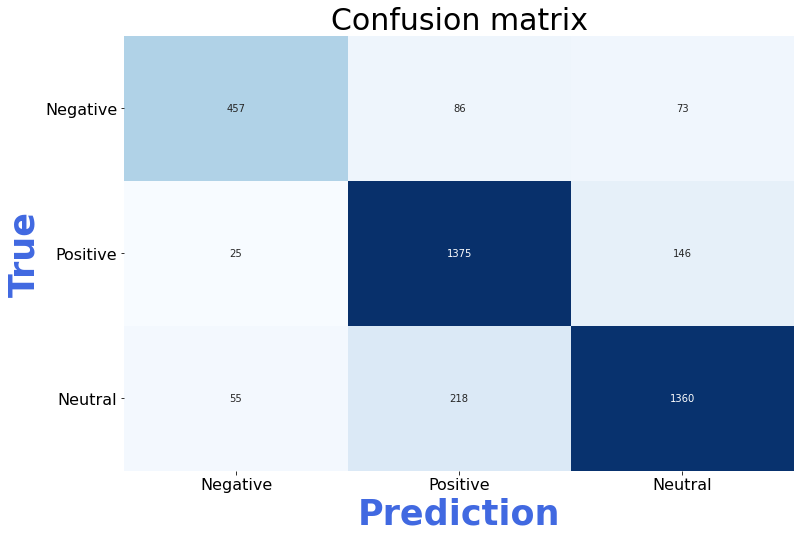

In [269]:
## Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xticklabels=list(y_test.unique()), yticklabels=list(y_test.unique()), title="Confusion matrix")
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("True", color="royalblue", fontsize=35, fontweight=700)
ax.set_xlabel("Prediction", color="royalblue", fontsize=35, fontweight=700)
plt.yticks(rotation=0);

<b>ROC and precision-recall curves</b>

In [270]:
y_test_array = pd.get_dummies(y_test_mapped, drop_first=False).values
classes = y_train.unique()

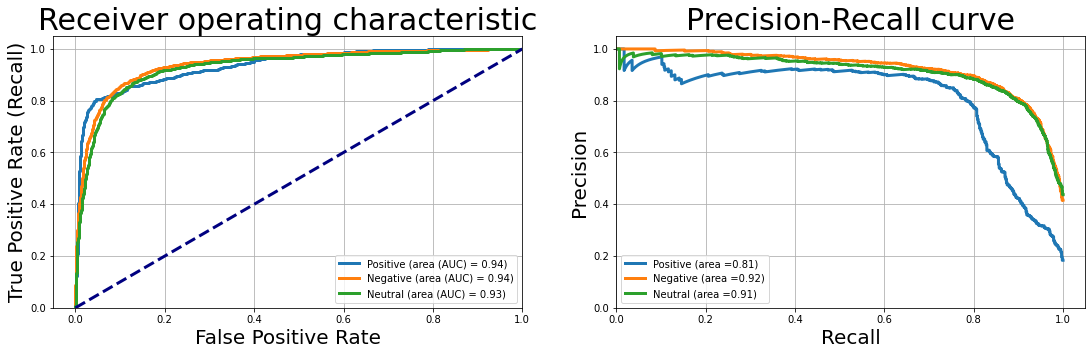

In [273]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 5)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area (AUC) = {1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area ={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

<div style="font-variant: small-caps; font-size:16pt; color:#104E8B; font-weight:700; width:80%; display:block; margin:auto; text-align:center">Thanks for reading, I hope you enjoyed it. If there is anything wrong or if you have any suggestions for improvement, please feel free to comment, I'll be glad to get feedback to improve.</div>